**Домашнее задание:**
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат

    Будем работать с данными для оценки стоимости автомобиля. Необходимо учесть что это ОЧЕНЬ старые данные, от 1997 года. Это необходимо учитывать при анализе, интерпретации и т.д. данных, т.к. там могут быть цены "ненормальные" для нас сегодня или например представленность марок автомобилей (каких то (современных/распространенных сейчас) не будет, а казалось бы должны быть, какие-то ушли с рынка и мы о них даже не помним/знаем и т.д.
    
    Вся информация при получении данных невероятно важна, так как позволяет нам получить общий концепт и впоследствии качественно обработать и интерпретировать полученные результаты. 

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
import shap
shap.initjs()



%matplotlib inline

C:\Users\User\AppData\Roaming\Python\Python39\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
C:\Users\User\AppData\Roaming\Python\Python39\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


Сделаем первые 2а пункта ДЗ:
    
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета 

Загрузим и посмотрим на наши данные:

In [77]:
car = pd.read_csv('C:/Users/User/Desktop/Машинное обучение в бизнесе/7/данные/CAR_EVALUATION.csv')
#car.head(30)
car.loc[car['Target'] == 'vgood']

,buying,maint,doors,persons,lug_boot,safety,Target
1097,med,med,2,4,big,high,vgood
1106,med,med,2,more,big,high,vgood
1124,med,med,3,4,big,high,vgood
1130,med,med,3,more,med,high,vgood
1133,med,med,3,more,big,high,vgood
...,...,...,...,...,...,...,...
1700,low,low,4,more,big,high,vgood
1715,low,low,5more,4,med,high,vgood
1718,low,low,5more,4,big,high,vgood
1724,low,low,5more,more,med,high,vgood


In [12]:
car.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   buying    1728 non-null   object
 1   maint     1728 non-null   object
 2   doors     1728 non-null   object
 3   persons   1728 non-null   object
 4   lug_boot  1728 non-null   object
 5   safety    1728 non-null   object
 6   Target    1728 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


! Попробуем ! посмотреть describe(). Почему попробуем, функция describe() хорошо работает с числовыми признаками, и показывает всю базовую статистическую информацию (min, max, std и т.д), что удобно, но у нас здесь все признаки объектные 

In [15]:
car.describe() 

,buying,maint,doors,persons,lug_boot,safety,Target
count,1728,1728,1728,1728,1728,1728,1728
unique,4,4,4,3,3,3,4
top,vhigh,vhigh,2,2,small,low,unacc
freq,432,432,432,576,576,576,1210


Посмотрим все уникальные значения в нашем df:

In [18]:
for col in car:
    print(car[col].unique())

['vhigh' 'high' 'med' 'low']
['vhigh' 'high' 'med' 'low']
['2' '3' '4' '5more']
['2' '4' 'more']
['small' 'med' 'big']
['low' 'med' 'high']
['unacc' 'acc' 'vgood' 'good']


Посмотрим на соотношение классов в таргете:

In [19]:
car['Target'].value_counts()

Target
unacc    1210
acc       384
good       69
vgood      65
Name: count, dtype: int64

По итогам базового анализа наших данных мы видим, что наш df содержит 7 признаков, таких как:     buying - цена покупки
    
    maint - цена обслуживания
    doors : количество дверей
    persons - вместимость с точки зрения кол-ва людей
    lug_boot - размер багажника
    safety - предполагаемая безопасность автомобиля
    Target - общая цена
И 1728 объектов.Все признаки являются объектными.Все признаки в нашем df имеют больше 2х уникальных значений, соответственно не о каком кодировании признаков в ручную даже речи быть не может, в такой ситуации нужно использовать OneHotEncoder.

По распределению признаков в таргете мы видим явный дисбаланс классов.

Опираясь на увиденное можно сделать вывод, что при выборе модели для ML нужно отдавать предпочтение моделям основанным на деревьях, т.к. они не настолько чувствительные к дисбалансам и одна из моделий может работать с категориальными признаками и т.д.  При необходимости можно взять и линейку, но тогда нужно будет провести объемную работу с данными.

Краткое сравнение 3х самых сильных моделей, основанных на деревьях:

В CatBoost деревья симметричные на каждом уровне, в двух других алгоритмах – ассиметричные. Таким образом, в LightGBM алгоритме деревья растут по листьям, горизонтально (leaf-wise growth), а в XGBoost деревья растут по уровням, вертикально (level-wise growth). В CatBoost используется жадный алгоритм разбиения наблюдений, в LightGBM используется Gradient-based One-Side Sampling, основанный на значениях градиента для наблюдений, а в XGBoost разбиение работает по предварительной сортировке значений признаков. На вход CatBoost могут подаваться категориальные признаки, LightGBM может принимать их на вход только в числовом формате, однако можно в порядковом виде. А XGBoost не может работать с порядковыми данными, категориальные признаки должны подаваться только после кодирования. 

Под мои потребности в этой задаче лучше всего подходит CatBoost, потому что  он хорошо работает с категориальными переменными. Как следует из названия, CatBoost означает «категорическое» повышение. Его можно использовать быстрее, чем, скажем, XGBoost, потому что он не требует предварительной обработки данных, которая может занять много времени.

**Подготовим данные к ML и обучим модель:**

In [21]:
X = car.drop('Target', axis=1)
y = car['Target']

Catboost необходимо сказать, какие признаки категориальные, для этого необходимо передать массив с индексами категориальных фичей:

In [27]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5]


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

Теперь переходим к обучению, здесь у нас будет два параметра – количество итераций и скорость обучения. Напомню, градиентный бустинг – это композиция решающих деревьев, каждое дерево строится последовательно, каждое последующее дерево компенсирует ошибки предсказания предыдущего дерева. По сути, число итераций – это количество деревьев. Если выставить скорость обучения высокой, то мы получим быстро переобучение, если слишком маленькой, то будем долго идти до некого оптимума.

In [36]:
#Здесь мы выставили параметр Verbose равный False, чтобы в stdout не выводилась никакая информация во время обучения. 
#После обучения вызовем метод is_fitted(), он показывает обучилась ли модели, второй параметр get_params(), 
#он покажет нам с какими параметрами происходило обучение модели. 

model = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.15,
    custom_loss=['AUC', 'Accuracy', 'F1']
)

model.fit(X_train, y_train,
         cat_features=cat_features,
         eval_set=(X_test, y_test),
          verbose=False,
          plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [47]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value[0], shap_values[0])

По оси X у нас расположена шкала вклада значения фичи, по оси Y — количество объектов.

Так же в Catboost есть shap.summary_plot(), который рисует по всей выборке такую же информацию, как и в предыдущих трех случаях:

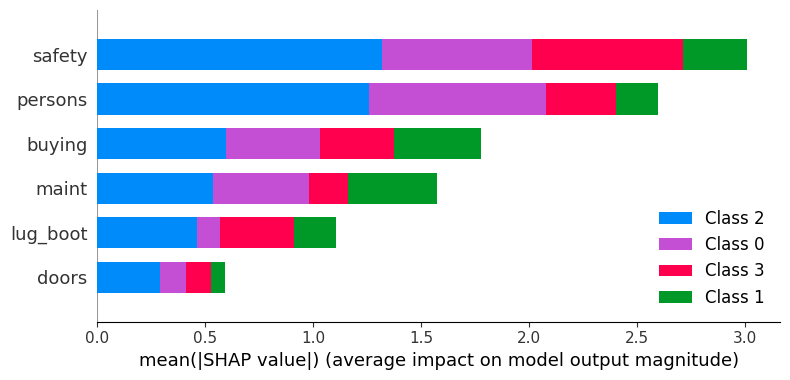

In [48]:
shap.summary_plot(shap_values, X_train)

Для класса очень хороших машин самыми важными признаками являются безопасность и количество людей к перевозке.
Для класса приемлемо самыми важными признаками выступают покупная цена и стоимость обслуживания.
Для класса хорошая, самым информативными является признак безопасности, следом по информативности идут признаки цена, размер багажника и кол-во людей к перевозке, т.к. они почти равны в этих трех признаках.
И для класса неприемлемо самым информативным будет признак кол-во людей к перевозке, после него безопасность, остальные значительно менее значимы для этого класса.
Эти данные можно использовать, к примеру, при планировании к выпуску новой машины, зная ее класс можно понять важные для потребителя особенности. Или если ты продаешь машины, какие лучше предложить к покупке тем или иным покупателям.